In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json

import os
import sys
import networkx as nx

plt.style.use('seaborn')
mpl.rc('image', cmap='bwr')
mpl.rc('axes', grid=False)

## Build POLITICS network

In [2]:
edges = pd.read_csv(
    "../data/processed/parent_child_sentiment_edges_politics.csv.bz2",
    index_col=0
)
net = nx.from_pandas_edgelist(edges, 'child', 'parent', 'sentiment', create_using=nx.DiGraph())
N=len(net)
E=net.number_of_edges()
kmed = float(E)/N
rho = nx.reciprocity(net)
print(N, E, kmed, rho)

31218 500030 16.017361778461144 0.44507729536227825


In [3]:
edges.head()

,parent,child,sentiment
0,fae83c5c68bc706c,441290880bbb7490,0.0000
1,ffe92102186d8670,e3f88b3430d253df,0.2732
2,d4f08edfcca59643,35514c4898239466,0.0000
3,be5f3b8eb7b8f85c,370cf738e4f3b228,0.7436
4,be5f3b8eb7b8f85c,7b5fc1d8ece515e5,0.3182


## Add leaning

In [4]:
author_label_state = pd.read_csv("../data/processed/author-label-state.csv.bz2", index_col=0)
author_label_state.head()

,author,label,state
0,770eb2c962a7d7e7,R,NaN
1,56a1cd58c7c60a37,R,NaN
2,1b6481c8b0058676,R,Illinois
3,e969ff0f2f47cd7f,R,Texas
4,16f6e7f0da5f1e52,R,Oregon


In [5]:
user_leaning = dict(pd.Series(author_label_state['label'].values, index=author_label_state.author))
nx.set_node_attributes(net, user_leaning, 'leaning')

In [6]:
rep_nodes = [x for x,d in net.nodes(data=True) if d['leaning']=='R']# and net.out_degree(x)>0]
dem_nodes = [x for x,d in net.nodes(data=True) if d['leaning']=='D']# and net.out_degree(x)>0]
print( N, len(rep_nodes), len(dem_nodes))

31218 27012 4206


## Compute E(x -> y) 

In [7]:
def attach_labels_to_graph_dataframe(edges, author2label):
    edges['lparent'] = edges.parent.map(author2label.get)
    edges['lchild'] = edges.child.map(author2label.get)
    return edges

In [8]:
author2label = dict(author_label_state[['author', 'label']].values)
edges = attach_labels_to_graph_dataframe(edges, author2label)
edges.head()

,parent,child,sentiment,lparent,lchild
0,fae83c5c68bc706c,441290880bbb7490,0.0000,D,R
1,ffe92102186d8670,e3f88b3430d253df,0.2732,R,D
2,d4f08edfcca59643,35514c4898239466,0.0000,R,R
3,be5f3b8eb7b8f85c,370cf738e4f3b228,0.7436,R,R
4,be5f3b8eb7b8f85c,7b5fc1d8ece515e5,0.3182,R,R


In [9]:
#compute P(X->), P(->Y), P_RN(X->Y)=P(X->)*P(->Y)
E_y_in = edges.groupby(['lparent']).child.count()/sum(edges.groupby(['lparent']).child.count())
E_x_out = edges.groupby(['lchild']).child.count()/sum(edges.groupby(['lchild']).child.count())
E_dot_xy = pd.DataFrame(E_y_in).dot(pd.DataFrame(E_x_out).T)
#plt.imshow(E_dot_xy.values)
E_dot_xy

lchild,D,R
lparent,,
D,0.118699,0.225679
R,0.225977,0.429645


In [10]:
#compute empirical P(x->y)
E_yin_xout = pd.DataFrame(edges.groupby(['lparent', 'lchild']).child.count()).unstack().child
E_yin_xout = E_yin_xout/E_yin_xout.values.sum()
E_yin_xout

lchild,D,R
lparent,,
D,0.097382,0.246996
R,0.247294,0.408328


0.08526778045128593


lchild,D,R
lparent,,
D,-0.021317,0.021317
R,0.021317,-0.021317


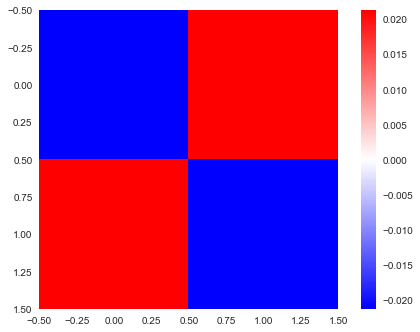

In [11]:
plt.imshow(E_yin_xout.subtract(E_dot_xy))
print(np.sum(np.abs(E_yin_xout.subtract(E_dot_xy).values)))
plt.colorbar()
E_yin_xout - E_dot_xy

Observe heterofily: more D->R and R->D interactions wrt RN

## Conditional prob

In [12]:
CP_yin_xout = E_yin_xout.div(E_x_out.T) # rows=child, col=parent
CP_yin_xout

lchild,D,R
lparent,,
D,0.282532,0.376907
R,0.717468,0.623093


0.18875027332547833


lchild,D,R
lparent,,
D,-0.061846,0.032529
R,0.061846,-0.032529


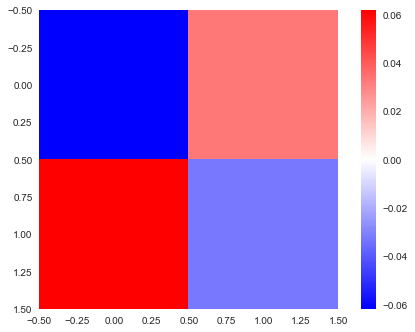

In [13]:
#diff_CP
diff_CP_xy = CP_yin_xout.subtract(E_y_in, axis=0) # subtraction col-wise -> axis=0
print(np.sum(np.abs(diff_CP_xy.values)))
plt.imshow(diff_CP_xy.values)
plt.colorbar()
diff_CP_xy

Observe asymmetry: much more D->R interactions, more R->D interactions wrt RN, 
much less D->D, less R->R ineractions